In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch import optim
from functorch import  make_functional
from torch.func import vmap, grad, jvp, vjp
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import Subset, DataLoader
from solvers.vanilla_lanczos import VanillaLanczos
from uncertainty.ggn import GGNMatVecOperator
import numpy as np

### workflow:
1. train NN on mps
2. conduct the GGN-vector product for tensors on mps
3. define the operator for cpu numpy: be careful about the dtype! (currently using `float32` for pytorch part)
4. apply Lanczos

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: mps


### Spectral Properties

- From C.1 Post-hoc orthogonalization (p.18), using MLP with 25818 params instead of LeNet with 44000 params

In [3]:
# 1. Load MNIST
transform = T.Compose([T.ToTensor(), T.Lambda(lambda x: x.view(-1))])
mnist = MNIST(root="./", train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=2000, shuffle=True)
X_batch, Y_batch = next(iter(loader))
X_batch = X_batch.float().to(device)
Y_batch = Y_batch.long().to(device)

# 2. Small model
class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )
    def forward(self, x):
        return self.net(x)
# device = torch.device("cpu")
model = SmallNet().to(device)

In [4]:
print(model)

SmallNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [6]:
# 3. Train 
def train(model, X, Y, epochs=300, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=1e-2)
    for epoch in range(epochs):
        opt.zero_grad()
        out = model(X)
        loss = F.cross_entropy(out, Y)
        loss.backward()
        opt.step()
        if epoch % 50 == 0 and verbose:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
        if epoch + 1 >= epochs and verbose:
            print(f'Epoch {epoch}, Final Loss: {loss.item()}')

In [7]:
train(model, X_batch, Y_batch, epochs=1000, verbose=False)

In [8]:
ggn_op = GGNMatVecOperator(model, X_batch, Y_batch, device=device)

/Users/csy/Desktop/sp2/demo/uncertainty/ggn.py:17: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  self.fmodel, self.params = make_functional(model)


In [9]:
EPOCHS_BASED_ON_SIZE = {10: 300, 100: 100, 1000: 50}
sample_sizes = [10, 100, 1000]
lanczos_steps = [10, 100, 1000]
results = {}
for n_samples in [10, 100, 1000]:
    # 1. Subsample
    X_sub = X_batch[:n_samples]
    Y_sub = Y_batch[:n_samples]

    # 2. New model
    model = SmallNet().to(device)
    train(model, X_sub, Y_sub, epochs=EPOCHS_BASED_ON_SIZE[n_samples], verbose=False)

    # 3. Build matvec
    ggn_op = GGNMatVecOperator(model, X_sub, Y_sub, device=device)
    # ggn_mv_torch = make_ggn_matvec_operator(model, X_sub, Y_sub )

    # def ggn_mv_numpy(v_np):
    #     return ggn_mv_torch(torch.from_numpy(v_np).float()).detach().cpu().numpy()

    # 4. Run Lanczos for different steps
    num_params = sum(p.numel() for p in model.parameters())

    for steps in lanczos_steps:
        print(f"Running: samples={n_samples}, steps={steps}")
        solver = VanillaLanczos(G_matvec=ggn_op.numpy_interface, p=num_params)
        solver.run(num_steps=steps)
        _, evals = solver.get_top_ritzpairs()
        key = (n_samples, steps)
        results[key] = evals

/Users/csy/Desktop/sp2/demo/uncertainty/ggn.py:17: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  self.fmodel, self.params = make_functional(model)


Running: samples=10, steps=10
Running: samples=10, steps=100
Running: samples=10, steps=1000
Running: samples=100, steps=10
Running: samples=100, steps=100
Running: samples=100, steps=1000
Running: samples=1000, steps=10
Running: samples=1000, steps=100
Running: samples=1000, steps=1000


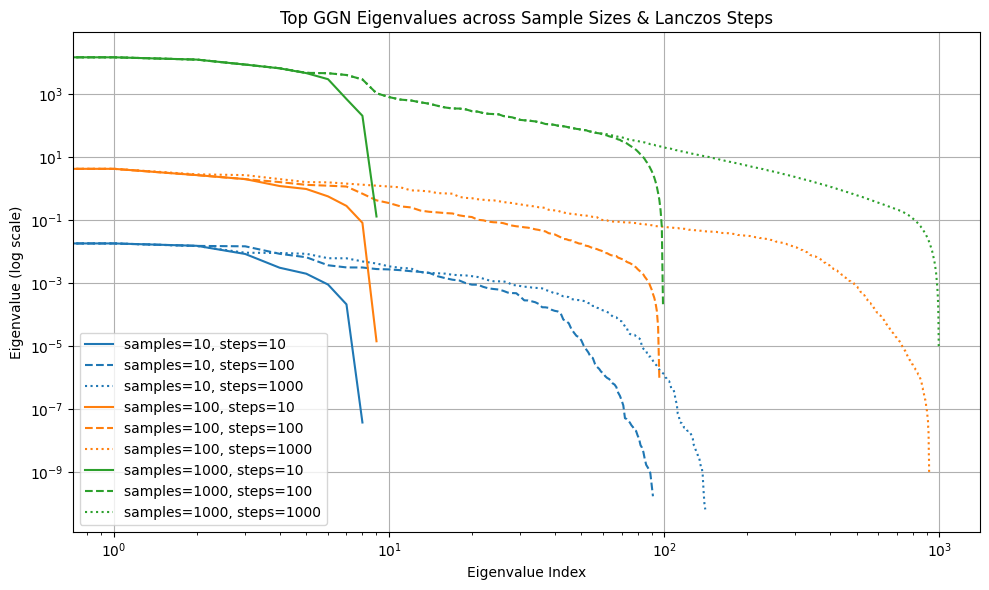

In [10]:
import matplotlib.pyplot as plt
sample_colors = {
    10: "tab:blue",
    100: "tab:orange",
    1000: "tab:green"
}
step_styles = {
    10: "-",
    100: "--",
    1000: ":"
}

plt.figure(figsize=(10, 6))

for (samples, steps), evals in results.items():
    clean_evals = evals[evals > 0]
    color = sample_colors[samples]
    linestyle = step_styles[steps]
    label = f"samples={samples}, steps={steps}"
    plt.plot(clean_evals, color=color, linestyle=linestyle, label=label)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Top GGN Eigenvalues across Sample Sizes & Lanczos Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Post-hoc orthogonalization
- run 50 steps, top 45 (90%) eigenpairs
- top-5 principle components

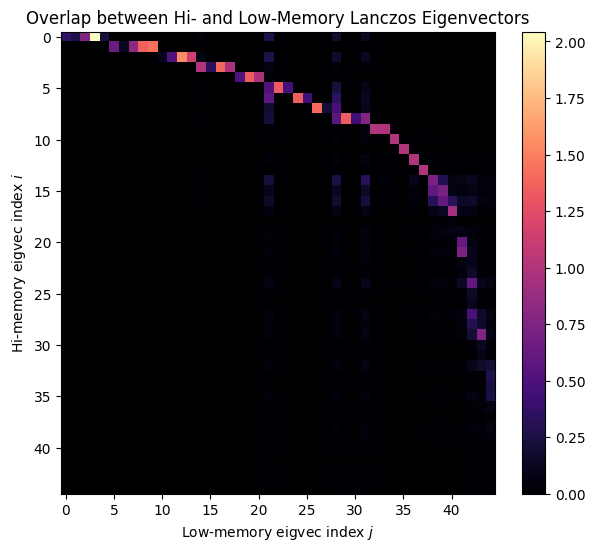

In [19]:
n = num_params
num_steps = 50
top_k = int(num_steps*0.9)

# hi-memory 
solver_hm = VanillaLanczos(G_matvec=ggn_op.numpy_interface, p=n)
solver_hm.run(num_steps)

# low-memory 
solver_lm = VanillaLanczos(G_matvec=ggn_op.numpy_interface, p=n, reorth=False, store_full_basis=True)
solver_lm.run(num_steps)

vecs_hm, vals_hm = solver_hm.get_top_ritzpairs(k=top_k, return_vectors=True)
vecs_lm, vals_lm = solver_lm.get_top_ritzpairs(k=top_k, return_vectors=True)

# vecs_hm = normalize_columns(vecs_hm)
# vecs_lm = normalize_columns(vecs_lm)

overlap = np.abs(vecs_hm.T @ vecs_lm)

# Plot
plt.figure(figsize=(7, 6))
plt.imshow(overlap, cmap="magma", interpolation="nearest", aspect="auto")
plt.colorbar()
plt.title("Overlap between Hi- and Low-Memory Lanczos Eigenvectors")
plt.xlabel("Low-memory eigvec index $j$")
plt.ylabel("Hi-memory eigvec index $i$")
plt.show()

In [168]:
from numpy.linalg import norm, svd
# L * Gamma_L and H * Gamma_H
weighted_lm = vecs_lm[:, :top_k] * vals_lm[:top_k]  # broadcast multiply
weighted_hm = vecs_hm[:, :top_k] * vals_hm[:top_k]

# SVD 
U_lm, a, _ = svd(weighted_lm, full_matrices=False)
U_hm, b, _ = svd(weighted_hm, full_matrices=False)

In [ ]:
from scipy.linalg import subspace_angles
# projection matrices from top-5 principal components
Q_lm = U_lm[:, :5]
Q_hm = U_hm[:, :5]
# Q_lm, Q_hm are (p x 5), orthonormal basis
angles = subspace_angles(Q_lm, Q_hm)  # returns array of 5 principal angles in radians

# operator norm difference ≈ sin(max angle)
proj_diff_fast = np.sin(angles[0])


In [174]:
proj_diff_fast

0.06389635659259775

In [ ]:
# mat-vec multiplication
def proj(Q, x):
    return Q @ (Q.T @ x)

# A @ x = (Pi_lm - Pi_hm) @ x
def proj_diff_mv(x):
    return proj(Q_lm, x) - proj(Q_hm, x)

# Power method to approximate ||Pi_lm - Pi_hm||_2
def power_method(mv_func, dim, n_iter=100, tol=1e-6):
    x = np.random.randn(dim)
    x = x / np.linalg.norm(x)
    prev_lambda = 0.0

    for i in range(n_iter):
        y = mv_func(x)
        lambda_ = np.linalg.norm(y)
        x = y / lambda_
        if abs(lambda_ - prev_lambda) < tol:
            break
        prev_lambda = lambda_

    return lambda_

proj_norm = power_method(proj_diff_mv, dim=num_params)
proj_norm

0.06389635656109784